In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
data_path = os.path.dirname(os.getcwd())

In [3]:
data = pd.read_csv(data_path+'/Data/Class imbalance/creditcard_csv.csv')
data.Class.replace(["'0'","'1'"],[0,1],inplace=True)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.Class.value_counts() #Label counts

0    284315
1       492
Name: Class, dtype: int64

In [5]:
data.isna().values.any() #Check if any NaN value

False

In [6]:
def sample_normalize_dataset(df, label):
    #df_y = df.pop(label)
    #df_x = (df-df.mean())/df.std()
    np.random.seed(2)
    test_indices = np.zeros(52092)
    class_1_indices = df[df.Class==1].index.values
    test_indices[:92] = np.random.choice(class_1_indices,size=92, replace=False)
    class_0_indices = df[df.Class==0].index.values
    test_indices[92:] = np.random.choice(class_0_indices,size=52000, replace=False)
    
    test_df = df.iloc[test_indices]
    train_df = df.drop(test_indices)
    
    train_df_y = train_df.pop(label)
    test_df_y = test_df.pop(label)
    
    mu = train_df.mean()
    std_dev = train_df.std()
    
    train_df_x = (train_df-mu)/std_dev
    test_df_x = (test_df-mu)/std_dev
    
    train_df_x.reset_index(drop=True, inplace=True),
    train_df_y.reset_index(drop=True, inplace=True)
    test_df_x.reset_index(drop=True, inplace=True) 
    test_df_y.reset_index(drop=True, inplace=True)
            
    return train_df_x, train_df_y, test_df_x, test_df_y

In [7]:
df_train_x, df_train_y, df_test_x, df_test_y = sample_normalize_dataset(data, "Class")

In [8]:
def precision(y_true, y_predicted, k):
    idx = np.argsort(y_predicted)
    #print(y_true[idx[-k:]])
    tp = np.sum(y_true[idx[-k:]])
    #print(tp)
    return tp/k

In [9]:
def fit_model(train_X, train_Y, test_X, test_Y, k_precision, weights=None):
    auc_scores={}
    nll_scores={}
    precision_scores={}
    n_est = [100, 500]
    maximum_depth = [2,5,10]
    ms_leaf = [2,5,10]
    for n in n_est:
        for d in maximum_depth:
            for m in ms_leaf:
                clf = RandomForestClassifier(n_estimators=n, 
                                             criterion='entropy',
                                             max_depth=d,
                                             min_samples_leaf = m,
                                             random_state=0).fit(train_X, train_Y)
                predicted_Y = clf.predict_proba(test_X)
                nll_scores['{},{},{}'.format(n,d,m)] = log_loss(test_Y, predicted_Y[:,1])
                auc_scores['{},{},{}'.format(n,d,m)] = roc_auc_score(test_Y, clf.predict(test_X))
                precision_scores['{},{},{}'.format(n,d,m)] = precision(test_Y, predicted_Y[:,1], k_precision)
    idx = max(auc_scores, key=auc_scores.get)
    return auc_scores[idx], nll_scores[idx], precision_scores[idx]

### Full dataset

In [ ]:
auc_full, nll_full, prec_full = fit_model(df_train_x, df_train_y, df_test_x, df_test_y, 20)

In [ ]:
print('AUC:{} | NLL Loss: {} | Precision@10: {}'.format(auc_full, nll_full, prec_full))

### Undersampling 

In [10]:
def undersample(df_X, df_Y, n_samples):
    undersampled_indices=np.zeros(n_samples+400)
    class_0_indices = df_Y[df_Y==0].index.values
    undersampled_indices[:n_samples] = np.random.choice(class_0_indices,size=n_samples, replace=False)
    undersampled_indices[n_samples:] = df_Y[df_Y==1].index.values
    undersampled_X = df_X.iloc[undersampled_indices]
    undersampled_Y = df_Y.iloc[undersampled_indices]
    undersampled_X.reset_index(drop=True, inplace=True)
    undersampled_Y.reset_index(drop=True, inplace=True)
    
    return undersampled_X,undersampled_Y 

In [13]:
def train_test_model(frac, df_train_x, df_train_y, df_test_x, df_test_y, k, weights=None):
    plt.figure(figsize=(12,12))
    plt.subplot(211)
    ax1 = plt.subplot(3, 1, 1)
    ax1.set_xscale('log')
    ax1.set_xlabel('Imbalance fraction')
    ax1.set_ylabel('NLL')
    ax2 = plt.subplot(3, 1, 2)
    ax2.set_xscale('log')
    ax2.set_xlabel('Imbalance fraction')
    ax2.set_ylabel('AUC')
    ax3 = plt.subplot(3, 1, 3)
    ax3.set_xscale('log')
    ax3.set_xlabel('Imbalance fraction')
    ax3.set_ylabel('Precision@{}'.format(k))
    
    n_bootstrap = 10
    auc_frac = {}
    nll_frac = {}
    prec_frac={}
    mean_auc_us = []
    std_auc_us = []
    std_nll_us = []
    mean_nll_us = []
    std_prec_us = []
    mean_prec_us = []
    for f in tqdm(frac):
        auc_frac[f] = np.zeros(n_bootstrap)
        nll_frac[f] = np.zeros(n_bootstrap)
        prec_frac[f] = np.zeros(n_bootstrap)
        for i in range(n_bootstrap):
            df_us_train_x, df_us_train_y = undersample(df_train_x, df_train_y, int(f*400))
            auc_us, nll_us, prec_us = fit_model(df_us_train_x, df_us_train_y, df_test_x, df_test_y, k, weights)
            auc_frac[f][i] = auc_us
            nll_frac[f][i] = nll_us
            prec_frac[f][i] = prec_us
            
        mean_auc_us.append(np.mean(auc_frac[f], axis=0))
        std_auc_us.append(np.std(auc_frac[f], axis=0))
        mean_nll_us.append(np.mean(nll_frac[f], axis=0))
        std_nll_us.append(np.std(nll_frac[f], axis=0))
        mean_prec_us.append(np.mean(prec_frac[f], axis=0))
        std_prec_us.append(np.std(prec_frac[f], axis=0))
        
        
    ax1.errorbar(frac, mean_nll_us, std_nll_us)
        
    ax2.errorbar(frac, mean_auc_us, std_auc_us)
    
    ax3.errorbar(frac, mean_prec_us, std_prec_us)
        
    plt.show()


100%|██████████| 3/3 [5:08:24<00:00, 5553.90s/it]

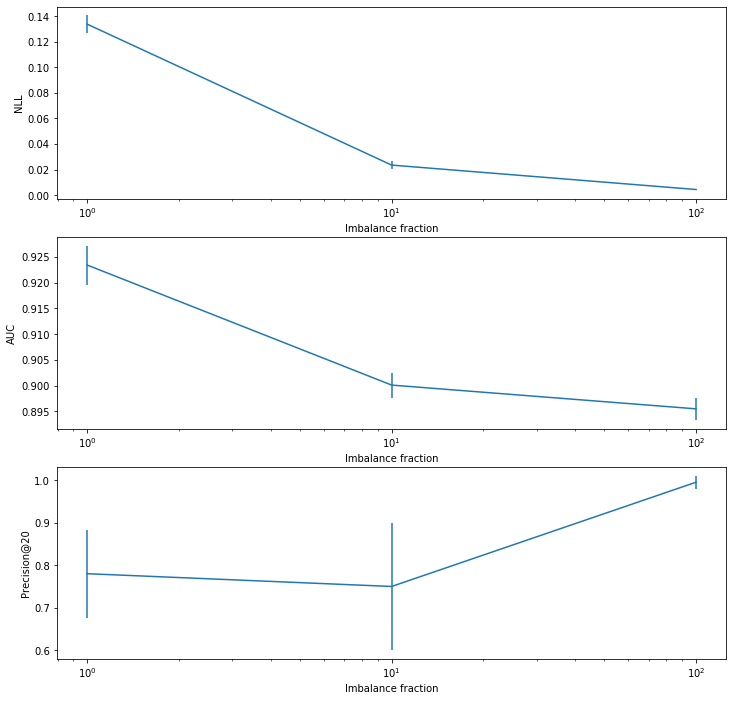

In [14]:
train_test_model([1,10,100], df_train_x, df_train_y, df_test_x, df_test_y, 20)

### Undersampling with weighing undersampled instances to match test distribution 


100%|██████████| 3/3 [2:31:12<00:00, 2725.03s/it]

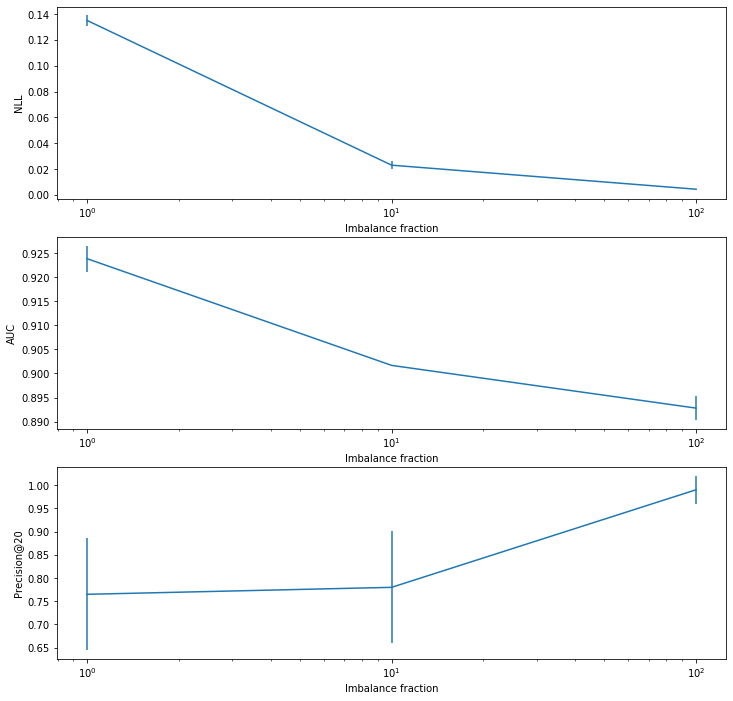

In [16]:
w = dict(data.Class.value_counts()/data.shape[0])
train_test_model([1,10,100], df_train_x, df_train_y, df_test_x, df_test_y, 20, w)